In [16]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from transformers import CLIPVisionModelWithProjection, AutoModelForCausalLM
from transformers import AutoModel, AutoTokenizer, OPTForCausalLM, BloomForCausalLM
import numpy

model_list = [
    'meta-llama/Meta-Llama-3-8B',
    # 'meta-llama--Llama-2-7b-hf'
]
model_name = model_list[0]
model_name = model_name.replace('/', '--')
print('model_name: ', model_name)

model_path = f"../Wparam_dataset/hf_model/{model_name}"
model = AutoModelForCausalLM.from_pretrained(model_path, local_files_only=True)

# original_weights = torch.randn(4096, 11008, dtype=torch.float32)
# original_weights = model.model.layers[10].self_attn.q_proj.weight.data
original_weights = model.model.layers[10].mlp.up_proj.weight.data

# 가중치 텐서의 일부(512x512)를 잘라내어 분석 (시각화를 위해)
weight_slice = original_weights[:512, :512].numpy()


# --- 유틸리티 함수 ---

def get_magnitude_spectrum(matrix):
    """2D 행렬을 입력받아 주파수 스펙트럼을 반환하는 함수"""
    f = np.fft.fft2(matrix)
    fshift = np.fft.fftshift(f)
    spectrum = 20 * np.log(np.abs(fshift) + 1)
    return spectrum

# --- 2. 압축 수행 ---

# (A) 양자화 (INT4 예시)
def quantize_dequantize(weights, bits=4):
    """가중치를 양자화 및 역양자화하여 복원"""
    # 스케일과 제로포인트 계산
    scale = (weights.max() - weights.min()) / (2**bits - 1)
    zeropoint = np.round(-weights.min() / scale)
    
    # 양자화 및 역양자화
    quantized = np.round(weights / scale + zeropoint)
    dequantized = (quantized - zeropoint) * scale
    return dequantized

quantized_weights = quantize_dequantize(weight_slice, bits=4)


# (B) JPEG 압축
def jpeg_compress_decompress(weights, quality=10):
    """가중치를 이미지처럼 취급하여 JPEG 압축 및 복원"""
    # 0-255 범위로 정규화
    min_val, max_val = weights.min(), weights.max()
    normalized = 255 * (weights - min_val) / (max_val - min_val)
    normalized = normalized.astype(np.uint8)
    
    # JPEG 압축/복원
    _, encoded_img = cv2.imencode('.jpg', normalized, [cv2.IMWRITE_JPEG_QUALITY, quality])
    decoded_img = cv2.imdecode(encoded_img, cv2.IMREAD_GRAYSCALE)
    
    # 원래 스케일로 역정규화
    denormalized = decoded_img.astype(np.float32) / 255 * (max_val - min_val) + min_val
    return denormalized

jpeg_weights = jpeg_compress_decompress(weight_slice, quality=10)


# --- 3. 주파수 스펙트럼 분석 및 오차 계산 ---

# 각 가중치의 스펙트럼 계산
original_spec = get_magnitude_spectrum(weight_slice)
quantized_spec = get_magnitude_spectrum(quantized_weights)
jpeg_spec = get_magnitude_spectrum(jpeg_weights)

# 오차 스펙트럼 계산
quant_error_spec = np.abs(original_spec - quantized_spec)
jpeg_error_spec = np.abs(original_spec - jpeg_spec)

quant_error_norm = (quant_error_spec - np.min(quant_error_spec)) / (np.max(quant_error_spec) - np.min(quant_error_spec))
jpeg_error_norm = (jpeg_error_spec - np.min(jpeg_error_spec)) / (np.max(jpeg_error_spec) - np.min(jpeg_error_spec))



model_name:  meta-llama--Meta-Llama-3-8B


Loading checkpoint shards:  29%|██▊       | 2/7 [00:00<00:00,  7.65it/s]

Loading checkpoint shards: 100%|██████████| 7/7 [00:00<00:00,  8.01it/s]


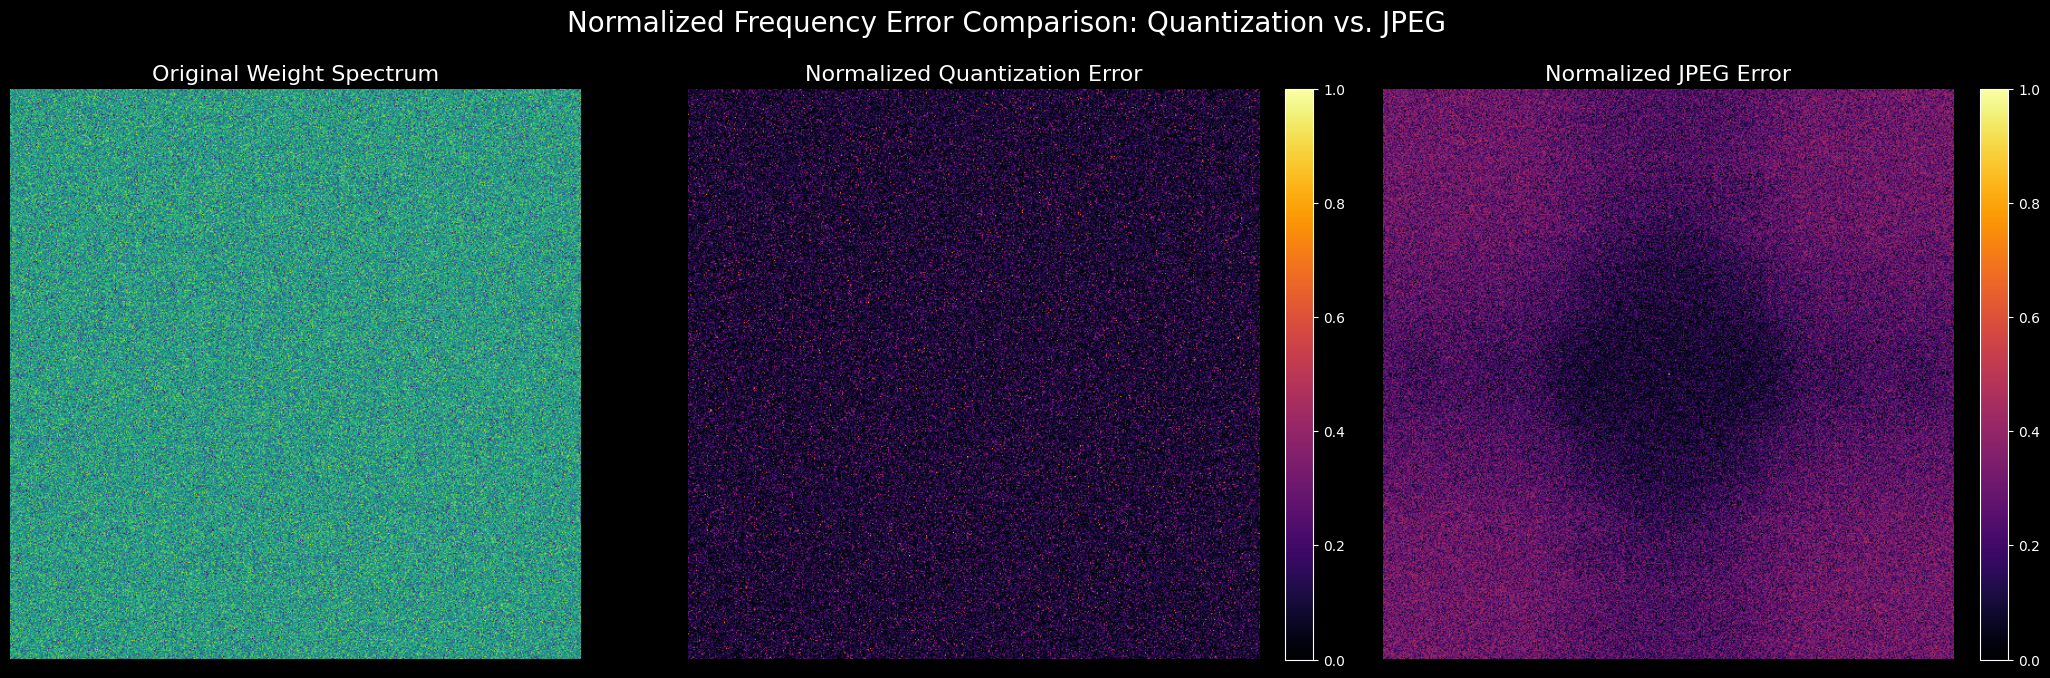

In [17]:
# --- 4. 시각화 (컬러바 수정) ---
# plt.style.use('dark_background')
# plt.style.use('background')
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

# 원본 가중치 스펙트럼
axes[0].imshow(original_spec, cmap='viridis')
axes[0].set_title('Original Weight Spectrum', fontsize=16)
axes[0].axis('off')

# 정규화된 양자화 오차 스펙트럼 + 개별 컬러바
im1 = axes[1].imshow(quant_error_norm, cmap='inferno')
axes[1].set_title('Normalized Quantization Error', fontsize=16)
axes[1].axis('off')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04) # 양자화 오차 플롯의 컬러바

# 정규화된 JPEG 오차 스펙트럼 + 개별 컬러바
im2 = axes[2].imshow(jpeg_error_norm, cmap='inferno')
axes[2].set_title('Normalized JPEG Error', fontsize=16)
axes[2].axis('off')
fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04) # JPEG 오차 플롯의 컬러바

plt.suptitle('Normalized Frequency Error Comparison: Quantization vs. JPEG', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()